In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import PIL.Image
from model.tetris import Tetris
from model.board import Board


import base64
import imageio
import IPython
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

from tf_agents.environments.parallel_py_environment import ParallelPyEnvironment

2022-12-23 00:45:40.934423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 00:45:41.664706: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.3.222/linux/mpi/intel64/lib:/opt/intel/compilers_and_libraries_2018.3.222/linux/mpi/mic/lib:/opt/intel/compilers_and_libraries_2018.3.222/linux/mpi/intel64/lib:/opt/intel/compilers_and_libraries_2018.3.222/linux/mpi/mic/lib::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2022-12-23 0

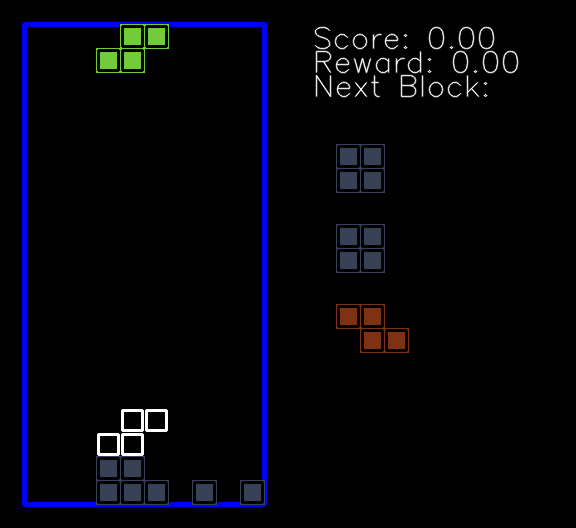

In [2]:
# GAME SETTING
BOARD_SIZE_W, BOARD_SIZE_H = BOARD = (10, 20)

# SCREEN SETTING
BLOCK_SIZE_W, BLOCK_SIZE_H = BLOCK_SIZE = (24, 24)
PADDING_X, PADDING_Y = PADDING = (24, 24)
WINDOW_SIZE_W, WINDOW_SIZE_H = WINDOW_SIZE = (PADDING_X * 2 + BOARD_SIZE_W * BLOCK_SIZE_W, PADDING_Y * 2 + BOARD_SIZE_H * BLOCK_SIZE_H)
env = Tetris(WINDOW_SIZE, PADDING, BOARD, BLOCK_SIZE)
PIL.Image.fromarray(env.render())

ret: (False, 0.01, array([20, 20, 18, 20, 19, 20, 20, 20, 20, 20,  0,  0,  3,  4,  4,  1,  0,
        1,  0,  1,  7,  5,  4,  0], dtype=int32))


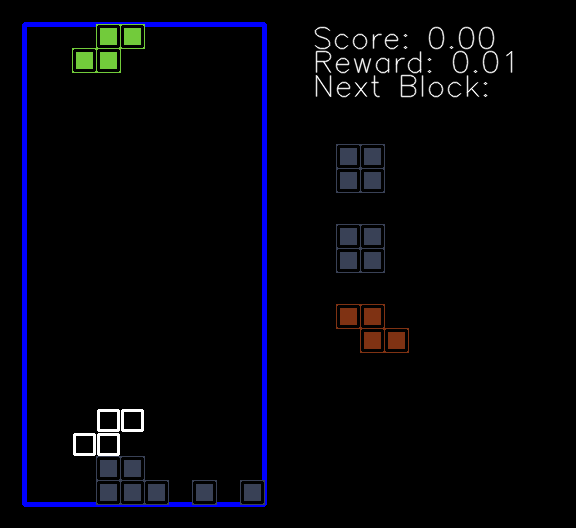

In [3]:
ret = env.board.take_action(0)
print(f'ret: {ret}')
PIL.Image.fromarray(env.render())

In [4]:
env.board.state

array([20, 20, 18, 20, 19, 20, 20, 20, 20, 20,  0,  0,  3,  4,  4,  1,  0,
        1,  0,  1,  7,  5,  4,  0], dtype=int32)

In [5]:
# raise Exception('STOP!')

In [6]:
num_iterations = 10_000 # @param {type:"integer"}

collect_steps_per_iteration = 20 # @param {type:"integer"}
replay_buffer_max_length = 1_000_000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 2e-4  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [7]:
from tf_agents.environments import utils

utils.validate_py_environment(env, episodes=20)

In [8]:
train_env = tf_py_environment.TFPyEnvironment(env)
eval_env = tf_py_environment.TFPyEnvironment(env)

In [9]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=15):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(env.render())
  return embed_mp4(filename)

In [10]:
fc_layer_params = (256, 256, 128, 128, 64)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.elu,
        # kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'),
        kernel_initializer=tf.keras.initializers.he_normal,# tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=None),
        bias_initializer=tf.keras.initializers.he_normal, #tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=None),
    )

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    # activation=tf.keras.activations.,
    activation=None,
    # kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03),
    # bias_initializer=tf.keras.initializers.Constant(-0.2)
    # kernel_initializer=tf.keras.initializers.he_normal, #tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=None),
    # bias_initializer=tf.keras.initializers.he_normal, #tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=None),
)
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter
)

agent.initialize()


2022-12-23 00:45:48.258532: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-23 00:45:48.258593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (notebookcompute007): /proc/driver/nvidia/version does not exist
2022-12-23 00:45:48.260684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [13]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [14]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [15]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

1.1965238

In [16]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpudwutdwe.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpudwutdwe
[reverb/cc/platform/default/server.cc:71] Started replay server on port 44871


In [17]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=8,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
  env,
  py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function=True),
  [rb_observer],
  max_steps=collect_steps_per_iteration,
  max_episodes=1
)

num_iterations = 200_000
iterator = iter(dataset)
for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (262168) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (262168) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (262168) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (262168) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (262168) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (262168) so Table uniform_table is accessed directly without gRPC.


step = 1000: loss = 9.199753761291504
step = 1000: Average Return = 1.324927568435669
step = 2000: loss = 37.11468505859375
step = 2000: Average Return = 1.0763957500457764
step = 3000: loss = 25.44182586669922
step = 3000: Average Return = 0.8004114031791687
step = 4000: loss = 22.069501876831055
step = 4000: Average Return = 0.1817447692155838
step = 5000: loss = 2.45503830909729
step = 5000: Average Return = 0.4934113919734955
step = 6000: loss = 4.013516902923584
step = 6000: Average Return = 1.3967984914779663
step = 7000: loss = 0.44788888096809387
step = 7000: Average Return = 0.4200781285762787
step = 8000: loss = 2.396674394607544
step = 8000: Average Return = 1.0624114274978638
step = 9000: loss = 8.800239562988281
step = 9000: Average Return = 0.9152446985244751
step = 10000: loss = 8.353069305419922
step = 10000: Average Return = 1.9247291088104248
step = 11000: loss = 4.100167751312256
step = 11000: Average Return = 0.47673696279525757
step = 12000: loss = 4.50445222854614

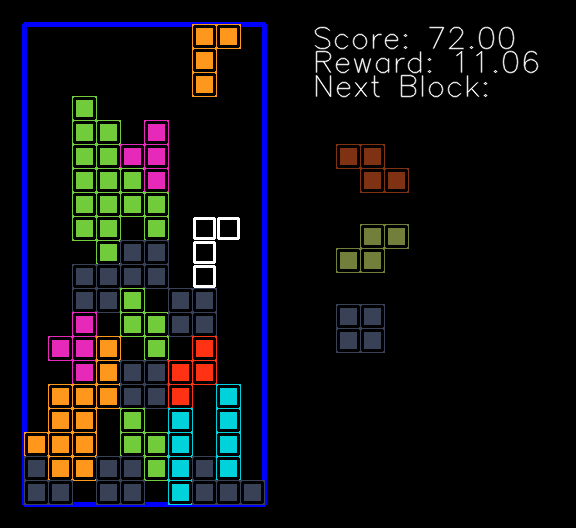

In [19]:
PIL.Image.fromarray(env.render())

In [20]:
# iterations = range(0, num_iterations + 1, eval_interval)
# plt.plot(iterations, returns)
# plt.ylabel('Average Return')
# plt.xlabel('Iterations')
# plt.ylim(top=250)

In [25]:
create_policy_eval_video(agent.policy, "trained-agent", fps=10)

In [26]:
create_policy_eval_video(random_policy, "random-agent")

In [28]:
import os
from tf_agents.policies import policy_saver

tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save('wheights/mark-001')

/home/azureuser/.local/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:521: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: wheights/mark-001/assets


INFO:tensorflow:Assets written to: wheights/mark-001/assets
